In [40]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import scipy.stats as st
import torch
import seaborn as sns
from scipy import stats

from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.ticker import StrMethodFormatter, ScalarFormatter



%matplotlib inline

plt.rc('font', size=16)
plt.rc('axes', titlesize=16)
plt.rc('axes', labelsize=16)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('legend', fontsize=16)
plt.rc('legend', title_fontsize=16)
plt.rc('legend', framealpha=0.0)
plt.rc('figure', titlesize=16)
plt.rc('lines', linewidth=3)

plt.rc('figure', figsize = [7,4])

### This notebook generates Figures 1, 2, 3, 7, 5, and 10
files required:
- 'spect_complexity_experiments_no_constraint_unequal_labels_10_randlabelscale_1000_epochs.pkl'
- 'spect_complexity_experiments_fr_constraint_unequal_labels_100_randlabelscale_1000_epochs.pkl'
- 'attack_set_with_control_dif_epochs_Nero_True_constraints_20000_epochs_0.9999_lrdecay_2_depth.pkl'
- 'generalization_scale_init_scale_SGD_False_constraints.pkl'
- 'generalization_scale_margin_scale_SGD_False_constraints.pkl'
- 'generalization_scale_margin_scale_Nero_True_constraints.pkl'




In [41]:
def get_margin_one_network(data_result, metric, other_metric, net_num, num_train_examples, to_normalize, normalization_string='bartlett_spect_complexity'):
    """Calculate margins for a single network
        to_normalize: True for spectrally normalization
    """
    margins = data_result[metric][net_num] - data_result[other_metric][net_num]
    if to_normalize:
        X_norm = data_result['X_norms'][net_num]
#         X_norm = 1
        margins /= data_result[normalization_string][net_num] * X_norm * (1/num_train_examples)
    return margins
# true_margins = get_margin_one_network(true_data_results, 'correct_class_outputs', 'other_class_outputs', net_num, to_normalize=False).numpy()


def get_all_margins_one_network(fname, net_num=0):
    f = open(fname, 'rb')
    results_dict = pickle.load(f)
    f.close()
    
    normalization_string = 'Frobenius normalization'
    num_train_examples = results_dict['parameters']['num_train_examples']
    num_networks = results_dict['parameters']['num_networks']
    parameters = results_dict['parameters']
    true_data_results = results_dict['true_data_results']
    rand_data_results = results_dict['rand_data_results']
    
    true_margins = get_margin_one_network(true_data_results, 'correct_class_outputs', 'other_class_outputs', net_num, num_train_examples, to_normalize=False).numpy()
    rand_margins = get_margin_one_network(rand_data_results, 'correct_class_outputs', 'other_class_outputs', net_num, num_train_examples, to_normalize=False).numpy()
    
    true_margins_normalized = get_margin_one_network(true_data_results, 'correct_class_outputs', 'other_class_outputs', net_num, num_train_examples, to_normalize=True).numpy()
    rand_margins_normalized = get_margin_one_network(rand_data_results, 'correct_class_outputs', 'other_class_outputs', net_num, num_train_examples, to_normalize=True).numpy()
    
    return true_margins, rand_margins, true_margins_normalized, rand_margins_normalized, results_dict


def margin_one_subplot(left_margins, right_margins, left_scale_target, right_scale_target, title, ylabel,
                       left_margins2, right_margins2, left_scale_target2, right_scale_target2, title2, ylabel2, C_left, C_right,
                       label_left, label_right):
    fig,(ax,ax2,ax3,ax4) = plt.subplots(1, 4, sharey=True)

    left_weights = np.ones_like(left_margins) / len(left_margins)
    ax.hist(left_margins, weights=left_weights, bins=bins, color=C_left)
    cur_min_left, cur_max_left = left_margins.min(), left_margins.max()
    cur_min_right, cur_max_right = right_margins.min(), right_margins.max()

    right_weights = np.ones_like(right_margins) / len(right_margins)
    ax2.hist(right_margins, weights=right_weights, bins=bins, color=C_right)


    ax.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax.yaxis.tick_left()
    ax.xaxis.tick_bottom()

    ax.xaxis.set_ticks([cur_min_left, left_scale_target, cur_max_left])
    ax.ticklabel_format(useOffset=False)
    ax.tick_params(axis='x', labelrotation= 45)
    ax2.xaxis.set_ticks([cur_min_right, right_scale_target, cur_max_right])
    ax2.tick_params(axis='x', labelrotation= 45)
    ax2.yaxis.tick_right()

    ax.set_title(title)
    ax.set_ylabel(ylabel)

    # plot the slices
    d = .015 # how big to make the diagonal lines in axes coordinates
    kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
    ax.plot((1-d,1+d),(-d,+d), **kwargs) # top-left diagonal
    ax.plot((1-d,1+d),(1-d,1+d), **kwargs) # bottom-left diagonal

    kwargs.update(transform=ax2.transAxes) # switch to the bottom axes
    ax2.plot((-d,d),(-d,+d), **kwargs) # top-right diagonal
    ax2.plot((-d,d),(1-d,1+d), **kwargs) # bottom-right diagonal
    # plot slices
    plt.subplots_adjust(wspace=0.15)
    
    left_weights2 = np.ones_like(left_margins2) / len(left_margins2)
    ax3.hist(left_margins2, weights=left_weights2, bins=bins, color=C_left, label=label_left)
    cur_min_left2, cur_max_left2 = left_margins2.min(), left_margins2.max()
    cur_min_right2, cur_max_right2 = right_margins2.min(), right_margins2.max()

    right_weights2 = np.ones_like(right_margins2) / len(right_margins2)
    ax4.hist(right_margins2, weights=right_weights2, bins=bins, color=C_right, label=label_right)


    ax3.spines['right'].set_visible(False)
    ax4.spines['left'].set_visible(False)
    ax3.yaxis.tick_left()
    ax3.xaxis.tick_bottom()

    ax3.xaxis.set_ticks([cur_min_left2, left_scale_target2, cur_max_left2])
    ax3.ticklabel_format(useOffset=False)
    ax3.tick_params(axis='x', labelrotation= 45)
    ax4.xaxis.set_ticks([cur_min_right2, right_scale_target2, cur_max_right2])
    ax4.tick_params(axis='x', labelrotation= 45)
    ax4.yaxis.tick_right()

    ax4.set_title(title2)
    ax3.set_ylabel(ylabel2)

    # plot the slices
    d = .015 # how big to make the diagonal lines in axes coordinates
    # arguments to pass plot, just so we don't keep repeating them
    kwargs = dict(transform=ax3.transAxes, color='k', clip_on=False)
    ax3.plot((1-d,1+d),(-d,+d), **kwargs) # top-left diagonal
    ax3.plot((1-d,1+d),(1-d,1+d), **kwargs) # bottom-left diagonal
    ax3.legend()

    kwargs.update(transform=ax4.transAxes) # switch to the bottom axes
    ax4.plot((-d,d),(-d,+d), **kwargs) # top-right diagonal
    ax4.plot((-d,d),(1-d,1+d), **kwargs) # bottom-right diagonal
    ax4.legend()
    # plot slices

    # Make the spacing between the two axes a bit smaller
    plt.subplots_adjust(wspace=0.15)
    
#   
    return fig, (ax, ax2, ax3, ax4)


def single_figure(left_margins, right_margins, left_scale_target, right_scale_target, title, ylabel, C_left, C_right, label_left, label_right, title_x_offset, title_y_offset):
    bins = 10
    if left_scale_target is None:
        left_scale_target = left_margins.mean()
    if right_scale_target is None:
        right_scale_target = right_margins.mean()
        
    fig,(ax,ax2, ax3) = plt.subplots(1, 3, sharey=True, gridspec_kw={'width_ratios': [0.25, 0.25, 0.5]})#, figsize=figsize)
    
    rounder = lambda x: np.round(x,2)
    left_weights = np.ones_like(left_margins) / len(left_margins)
    ax.hist(left_margins, weights=left_weights, bins=bins, color=C_left)
    
    cur_min_left, cur_max_left = rounder(left_margins.min()), rounder(left_margins.max())
    cur_min_right, cur_max_right = rounder(right_margins.min()), rounder(right_margins.max())

    right_weights = np.ones_like(right_margins) / len(right_margins)
    ax2.hist(right_margins, weights=right_weights, bins=bins, color=C_right)


    ax.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax.yaxis.tick_left()
    ax.xaxis.tick_bottom()
    ax.xaxis.set_ticks([left_scale_target])
    ax.ticklabel_format(useOffset=False)
    ax.tick_params(axis='x')#, labelrotation= 45)
    ax2.xaxis.set_ticks([right_scale_target])
    ax2.tick_params(axis='x')#, labelrotation= 45)
    ax2.yaxis.tick_right()
    ax.set_xlabel(title, x = title_x_offset, y=title_y_offset)
    ax.set_ylabel(ylabel)

    # plot the slices
    d = .015 # how big to make the diagonal lines in axes coordinates
    # arguments to pass plot, just so we don't keep repeating them
    kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
    ax.plot((1-d,1+d),(-d,+d), **kwargs) # top-left diagonal
    ax.plot((1-d,1+d),(1-d,1+d), **kwargs) # bottom-left diagonal

    kwargs.update(transform=ax2.transAxes) # switch to the bottom axes
    ax2.plot((-d,d),(-d,+d), **kwargs) # top-right diagonal
    ax2.plot((-d,d),(1-d,1+d), **kwargs) # bottom-right diagonal
    # plot slices
    plt.subplots_adjust(wspace=0.15)
    return fig, (ax, ax2, ax3)


def simple_hist(m1, m2, label1, label2, C1, C2, title, title_x_offset, title_y_offset=-0.4):
    bins=10
    weights1 = np.ones_like(m1) / len(m1)
    plt.hist(m1, label=label1, color=C1, weights=weights1, bins=bins)
    weights2 = np.ones_like(m2) / len(m2)
    plt.hist(m2, label=label2, color=C2, weights=weights2, bins=bins)
    plt.legend()
    fig = plt.gcf()
    ax = plt.gca()
    ax.tick_params(axis='x', labelrotation= 45)
    ax.set_xlabel(title, x=title_x_offset, y=title_y_offset)
    ax.xaxis.set_ticks([])

    
def single_figure_2(left_margins, right_margins, left_scale_target, right_scale_target, title, ylabel, C_left, C_right, label_left, label_right,
                   left_margins2, right_margins2, left_scale_target2, right_scale_target2, title2, ylabel2, C_left2, C_right2, label_left2, label_right2, title_x_offset=1.05, title_y_offset=-0.5):
    bins = 10
    if left_scale_target is None:
        left_scale_target = left_margins.mean()
    if right_scale_target is None:
        right_scale_target = right_margins.mean()
        
    fig,(ax,ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True)#, figsize=figsize)
    
    legend_elements = [Patch(facecolor='C0',
                         label='true'),
                       Patch(facecolor='C1',
                         label='rand')]

    ax.legend(handles=legend_elements, loc='upper left')#, loc='center')
    rounder = lambda x: np.round(x,5)


    left_weights = np.ones_like(left_margins) / len(left_margins)
    ax.hist(left_margins, weights=left_weights, bins=bins, color=C_left)
    cur_min_left, cur_max_left = rounder(left_margins.min()), rounder(left_margins.max())
    cur_min_right, cur_max_right = rounder(right_margins.min()), rounder(right_margins.max())

    right_weights = np.ones_like(right_margins) / len(right_margins)
    ax2.hist(right_margins, weights=right_weights, bins=bins, color=C_right)

    ax.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax.xaxis.tick_bottom()
    ax.ticklabel_format(axis="x", style="scientific", scilimits=(0,0), useOffset=False)
    ax2.ticklabel_format(axis="x", style="scientific", scilimits=(0,0), useOffset=False)
    ax.xaxis.set_ticks([left_scale_target])
    ax.tick_params(axis='x')#, labelrotation= 45)
    ax2.xaxis.set_ticks([right_scale_target])
    ax2.tick_params(axis='x')#, labelrotation= 45)
    ax.set_xlabel(title, x = title_x_offset, y=title_y_offset)
    ax.set_ylabel(ylabel)

    # plot the slices
    d = .015 # 
    kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
    ax.plot((1-d,1+d),(-d,+d), **kwargs) # top-left diagonal
    ax.plot((1-d,1+d),(1-d,1+d), **kwargs) # bottom-left diagonal

    kwargs.update(transform=ax2.transAxes) # switch to the bottom axes
    ax2.plot((-d,d),(-d,+d), **kwargs) # top-right diagonal
    ax2.plot((-d,d),(1-d,1+d), **kwargs) # bottom-right diagonal
    # plot slices

    # Make the spacing between the two axes a bit smaller
    plt.subplots_adjust(wspace=0.15)
    
############################### Second column
    left_weights2 = np.ones_like(left_margins2) / len(left_margins2)
    ax3.hist(left_margins2, weights=left_weights2, bins=bins, color=C_left2)
    cur_min_left2, cur_max_left2 = left_margins2.min(), left_margins2.max()
    cur_min_right2, cur_max_right2 = right_margins2.min(), right_margins2.max()

    right_weights2 = np.ones_like(right_margins2) / len(right_margins2)
    ax4.hist(right_margins2, weights=right_weights2, bins=bins, color=C_right2)
    ax3.spines['right'].set_visible(False)
    ax4.spines['left'].set_visible(False)
    ax3.xaxis.tick_bottom()
    ax3.xaxis.set_ticks([left_scale_target2])

    ax3.tick_params(axis='x')#, labelrotation= 45)
    ax4.xaxis.set_ticks([])
    ax4.tick_params(axis='x')#, labelrotation= 45)
    ax3.xaxis.set_ticks([])
    ax3.set_xlabel(title2, x = title_x_offset, y=title_y_offset)
    ax3.set_ylabel(ylabel2)
    ax3.ticklabel_format(axis="x", style="scientific", scilimits=(0,0), useOffset=True)
    ax4.ticklabel_format(axis="x", style="scientific", scilimits=(0,0), useOffset=True)
    d = .015 # how big to make the diagonal lines in axes coordinates
#     d = 0.018
    # arguments to pass plot, just so we don't keep repeating them
    kwargs = dict(transform=ax3.transAxes, color='k', clip_on=False)
    ax3.plot((1-d,1+d),(-d,+d), **kwargs) # top-left diagonal
    ax3.plot((1-d,1+d),(1-d,1+d), **kwargs) # bottom-left diagonal

    kwargs.update(transform=ax4.transAxes) # switch to the bottom axes
    ax4.plot((-d,d),(-d,+d), **kwargs) # top-right diagonal
    ax4.plot((-d,d),(1-d,1+d), **kwargs) # bottom-right diagonal
    # plot slices

    # Make the spacing between the two axes a bit smaller
    plt.subplots_adjust(wspace=0.15)
    return fig, (ax, ax2, ax3, ax4)


# Figure 1

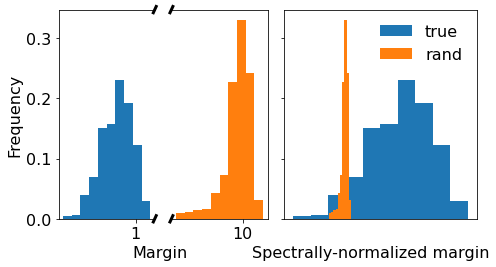

In [42]:
fname = 'spect_complexity_experiments_no_constraint_unequal_labels_10_randlabelscale_1000_epochs.pkl'

# Note that the xlimits will need to be changed to match the given dataset

true_margins, rand_margins, true_margins_normalized, rand_margins_normalized, results_dict = get_all_margins_one_network(fname)
fig, (ax, ax2, ax3) = single_figure(left_margins=true_margins,
                                    right_margins=rand_margins,
                                    left_scale_target=results_dict['parameters']['true_data_label_scale'],
                                    right_scale_target=results_dict['parameters']['rand_label_scale'],
                                    title='Margin',
                                    ylabel='Frequency',
                                    C_left='C0',
                                    C_right='C1',
                                    label_left='true',
                                    label_right='rand',
                                    title_x_offset=1.05,
                                    title_y_offset=-2.7
                                   )
axs = (ax, ax2, ax3)
spec = fig.add_gridspec(1,4)
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) # No decimal places
ax2.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) # No decimal places

simple_hist(true_margins_normalized, rand_margins_normalized, 'true', 'rand', 'C0', 'C1', title='Spectrally-normalized margin',
           title_x_offset=0.45,
            title_y_offset=-0.8)
aa = plt.gca()
aa.xaxis.set_major_formatter(StrMethodFormatter('{x:,.5f}'))
fig = plt.gcf()
ax2.tick_params(axis="y", right=False)
fig.align_labels()
plt.tight_layout(w_pad=.65)
# plt.savefig('figures_spectral_hist_standard.pdf')#, bbox_inches='tight')
plt.show()

# Figure 2

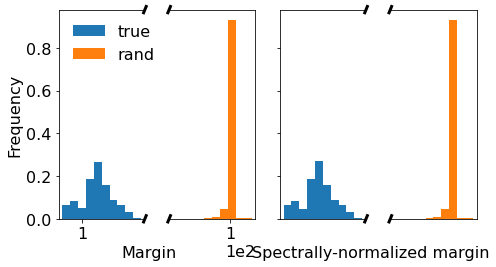

In [43]:
fname = 'spect_complexity_experiments_fr_constraint_unequal_labels_100_randlabelscale_1000_epochs.pkl'

# Change X limits appropriately

true_margins, rand_margins, true_margins_normalized, rand_margins_normalized, results_dict = get_all_margins_one_network(fname)
fig, (ax, ax2, ax3, ax4) = single_figure_2(left_margins=true_margins,
                               right_margins=rand_margins,
                               left_scale_target=results_dict['parameters']['true_data_label_scale'],
                               right_scale_target=results_dict['parameters']['rand_label_scale'],
                               title='Margin',
                               ylabel='Frequency',
                               C_left='C0',
                               C_right='C1',
                               label_left='true',
                               label_right='rand',
                               left_margins2=true_margins_normalized,
                               right_margins2=rand_margins_normalized,
                               left_scale_target2=true_margins_normalized.mean(),
                               right_scale_target2=rand_margins_normalized.mean(),
                               title2='Spectrally-normalized margin',
                               ylabel2=None,
                               C_left2='C0',
                               C_right2='C1',
                               label_left2='true',
                               label_right2='rand')
ax3.xaxis.set_major_formatter(StrMethodFormatter('{x:,.5f}')) # No decimal places
ax4.xaxis.set_major_formatter(StrMethodFormatter('{x:,.5f}')) # No decimal places

fig = plt.gcf()
fig.align_labels()

ax2.tick_params(axis="y", left=False)
ax4.tick_params(axis="y", left=False)
plt.tight_layout(w_pad=0.5)
# plt.savefig('figures_spectral_hist.pdf')#, bbox_inches='tight') #, bbox_inches='tight')
plt.show()




# Figure 3 and 7

In [25]:
fname = 'attack_set_with_control_dif_epochs_Nero_True_constraints_20000_epochs_0.9999_lrdecay_2_depth.pkl'

f = open(fname, 'rb')
results_dict = pickle.load(f)
f.close()

num_networks = results_dict['parameters']['num_networks']
parameters = results_dict['parameters']
true_data_results = results_dict['true_data_results']
control_data_results = results_dict['control_data_results']
num_train_examples = parameters['num_train_examples']

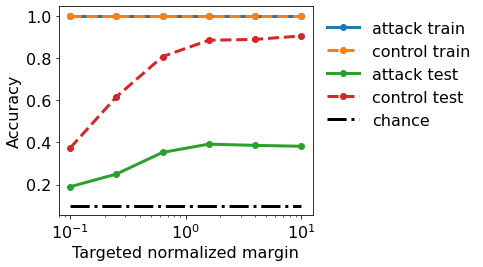

In [26]:
plt.plot(parameters['scale_vector'], [true_data_results['train_acc_list'][i][-1] for i in range(num_networks)], label='attack train', marker='o', linestyle='-')
plt.plot(parameters['scale_vector'], [control_data_results['train_acc_list'][i][-1] for i in range(num_networks)], label='control train', marker='o', linestyle='--')
plt.plot(parameters['scale_vector'], [true_data_results['test_acc_list'][i][-1] for i in range(num_networks)], label='attack test', marker='o', linestyle='-')
plt.plot(parameters['scale_vector'], [control_data_results['test_acc_list'][i][-1] for i in range(num_networks)], label='control test', marker='o', linestyle='--')
plt.hlines(1/10, min(parameters['scale_vector']), max(parameters['scale_vector']), 'k', '-.', label='chance')
plt.xlabel('Targeted normalized margin')
plt.ylabel('Accuracy')

plt.xscale('log')
fig = plt.gcf()
plt.legend()
ax = plt.gca()
ax.legend(bbox_to_anchor=(1, 1))
plt.tight_layout()
# plt.savefig("attack_summary.pdf")

In [27]:
def get_margin_one_network(data_result, metric, other_metric, net_num, to_normalize):
    """Calculate margins for a single network
        to_normalize: True for spectrally normalization
    """
    margins = data_result[metric][net_num] - data_result[other_metric][net_num]
    if to_normalize:
        X_norm = data_result['X_norms'][net_num]
#         X_norm = 1
        margins /= data_result['bartlett_spect_complexity'][net_num] * X_norm * (1/num_train_examples)
    return margins

train: 1.0, test: 0.3523
control train: 1.0, test: 0.8067


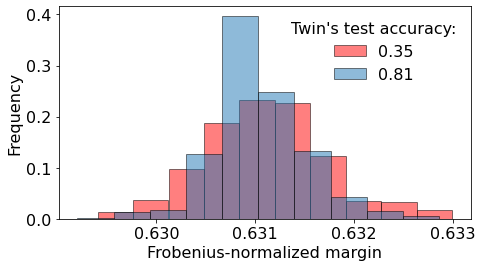

In [30]:
scale_vector =results_dict['parameters']['scale_vector']
net_num = 2
scale = scale_vector[net_num]
alpha = 0.5
true_margins = get_margin_one_network(true_data_results, 'correct_class_outputs', 'other_class_outputs', net_num = net_num, to_normalize=False).numpy()
true_margins = true_margins[:num_train_examples]
control_margins = get_margin_one_network(control_data_results, 'correct_class_outputs', 'other_class_outputs', net_num = net_num, to_normalize=False).numpy()
weights = np.ones_like(true_margins) / len(true_margins)
control_weights = np.ones_like(control_margins) / len(control_margins)
attack_test = true_data_results['test_acc_list'][net_num][-1]
control_test = control_data_results['test_acc_list'][net_num][-1]
plt.hist(true_margins, label=f'{np.round(attack_test,2)}', weights=weights, alpha=alpha, cumulative=False, color='red', edgecolor='k')
plt.hist(control_margins, label=f'{np.round(control_test,2)}', weights=control_weights, edgecolor='k', alpha=alpha, cumulative=False, color='C0')
plt.xlabel('Frobenius-normalized margin')
fig = plt.gcf()
plt.ylabel('Frequency')
print(f"train: {true_data_results['train_acc_list'][net_num][-1]}, test: {true_data_results['test_acc_list'][net_num][-1]}")
print(f"control train: {control_data_results['train_acc_list'][net_num][-1]}, test: {control_data_results['test_acc_list'][net_num][-1]}")

plt.locator_params(axis='x', nbins=5)
plt.legend(title="Twin's test accuracy:")
plt.tight_layout()

# plt.savefig('figure_attack_set_new.pdf')

# Figure 5 and 10

In [31]:
def plot_final_acc(fname, color, title):
    acc_thresh = 0.9
    
    f = open(fname, 'rb')
    results_dict = pickle.load(f)
    f.close()
    
    num_networks = results_dict['parameters']['num_networks']
    parameters = results_dict['parameters']
    true_data_results = results_dict['true_data_results']
    rand_data_results = results_dict['rand_data_results']
    num_train_examples = parameters['num_train_examples']
    
    
    if 'margin_scale' in fname:
        scale_vector = results_dict['parameters']['scale_vector']
        exp_string = 'Margin scale'
    elif 'init_scale' in fname:
        scale_vector = results_dict['parameters']['sigma_vector']
        exp_string = 'Init scale'
    
    if 'Nero' in fname:
        normalization_string = 'Frobenius Normalization'
    elif 'SGD' in fname:
        normalization_string = 'No Normalization'
        
    vals = [(scale_vector, train_acc, test_acc) for scale_vector, train_acc, test_acc in zip(
        scale_vector,
        [results_dict['true_data_results']['train_acc_list'][i][-1] for i in range(results_dict['parameters']['num_networks'])],
        [results_dict['true_data_results']['test_acc_list'][i][-1] for i in range(results_dict['parameters']['num_networks'])]) \
    if train_acc > acc_thresh ]
    
    scale_vector = [vals[i][0] for i in range(len(vals))]
    train_accs = [vals[i][1] for i in range(len(vals))]
    test_accs = [vals[i][2] for i in range(len(vals))]
    
    plt.plot(scale_vector[0], train_accs[0],
                color='k', label='Train')#, marker='s')
    plt.plot(scale_vector[0], test_accs[0],
                color=color, label='Test')
  
    plt.plot(scale_vector, train_accs,
                color='k')#, marker='s')
    plt.plot(scale_vector, test_accs,
                color=color)
    plt.xlabel(f'{exp_string}')
    plt.ylabel('Accuracy')
    plt.xscale('log')
    plt.title(f'{title}')
    if exp_string == 'margin scale':
        plt.legend(loc='lower right');
    else:
        plt.legend()
    fig = plt.gcf()


def get_prod_sqrt_widths(fname):
    f = open(fname, 'rb')
    results_dict = pickle.load(f)
    f.close()
    
    num_networks = results_dict['parameters']['num_networks']
    parameters = results_dict['parameters']
    true_data_results = results_dict['true_data_results']
    rand_data_results = results_dict['rand_data_results']
    num_train_examples = parameters['num_train_examples']
    
    return np.array([np.prod(norms) for norms in results_dict['true_data_results']['fro_norms']])[0]


def plot_final_acc_normalized_margin(fname, color, label, ls, marker, prod_sqrt_widths, normalize_by='fro_norms'):
    
    f = open(fname, 'rb')
    results_dict = pickle.load(f)
    f.close()
    
    num_networks = results_dict['parameters']['num_networks']
    parameters = results_dict['parameters']
    true_data_results = results_dict['true_data_results']
    rand_data_results = results_dict['rand_data_results']
    num_train_examples = parameters['num_train_examples']
    
    
    if 'margin_scale' in fname:
        scale_vector = results_dict['parameters']['scale_vector']
        exp_string = 'margin scale'
    elif 'init_scale' in fname:
        scale_vector = results_dict['parameters']['sigma_vector']
        exp_string = 'init scale'
    
    if 'Nero' in fname:
        normalization_string = 'Frobenius Normalization'
        opt_string = 'Nero'
    elif 'SGD' in fname:
        normalization_string = 'No Normalization'
        opt_string = 'SGD'
    
    if normalize_by == 'fro_norms':
        if exp_string == 'init scale':
            scale_vector = np.ones_like(scale_vector)
        normalized_margins = scale_vector /np.array([np.prod(norms) for norms in results_dict['true_data_results']['fro_norms']]) * prod_sqrt_widths#np.array([np.prod(norms) for norms in results_dict['true_data_results']['spect_norms']])

    vals = [(normalized_margin, train_acc, test_acc) for normalized_margin, train_acc, test_acc in zip(
        normalized_margins,
        [results_dict['true_data_results']['train_acc_list'][i][-1] for i in range(results_dict['parameters']['num_networks'])],
        [results_dict['true_data_results']['test_acc_list'][i][-1] for i in range(results_dict['parameters']['num_networks'])]) \
    if train_acc > 0.9 ]
    
    normalized_margin = [vals[i][0] for i in range(len(vals))]
    train_accs = [vals[i][1] for i in range(len(vals))]
    test_accs = [vals[i][2] for i in range(len(vals))]
    

    plt.plot(normalized_margin, test_accs,
                color=color, label=label, marker=marker, linestyle=ls)
    plt.ylim([0,1])

    plt.xlabel(f'Frobenius-normalized margin')
    plt.ylabel('accuracy')
    plt.xscale('log')
    plt.title(f'{label}')
    if exp_string == 'margin scale':
        plt.legend(title='Control:')#loc='lower right');
    else:
        plt.legend(title='Control:')

    return normalized_margins



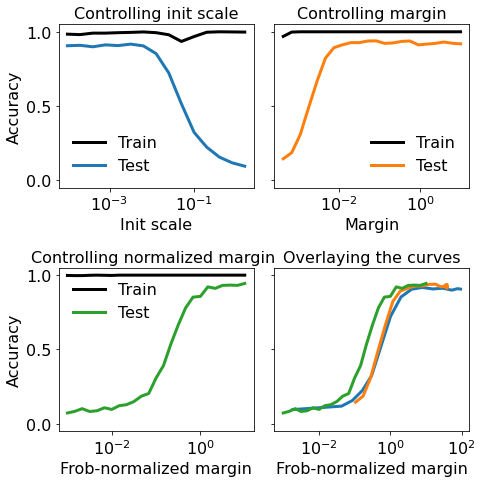

In [37]:
fnames = ['generalization_scale_init_scale_SGD_False_constraints.pkl',
          'generalization_scale_margin_scale_SGD_False_constraints.pkl',
          'generalization_scale_margin_scale_Nero_True_constraints.pkl']
prod_sqrt_w = get_prod_sqrt_widths(fname = 'generalization_scale_margin_scale_Nero_True_constraints.pkl')


c_list = ['C0', 'C1', 'C2']
label_list = ['init scale',
              'margin',
              'Frob-normalized margin']
    
for i, fname in enumerate(fnames):
    title=label_list[i]
    plt.subplot(2,2,i+1)
    plot_final_acc(fname, color=c_list[i], title=title)
    plt.ylim([-.05,1.05])
    if i+1 in [2,4]:
        plt.ylabel('')

    if i+1 == 1:
        plt.title('Controlling init scale')
        plt.yticks([0, 0.5, 1])


    elif i+1 == 2:
        plt.title('Controlling margin')
        plt.xlabel('Margin')
        plt.yticks([0, 0.5, 1], labels=[])


    elif i+1 == 3:
        plt.title('Controlling normalized margin ')
        plt.xlabel('Frob-normalized margin')
        plt.yticks([0, 0.5, 1])
    elif i+1 == 4:
        pass
fig = plt.gcf()

plt.subplot(2,2,4)
for idx, fname in enumerate(fnames):

        label = label_list[idx]
        normalized_margins = plot_final_acc_normalized_margin(fname, c_list[idx], label=label, ls='-', marker=None, prod_sqrt_widths=prod_sqrt_w)
        plt.ylabel('')
        plt.title('Overlaying the curves')
        plt.xlabel('Frob-normalized margin')
        plt.ylim([-.05,1.05])


        plt.yticks([0, 0.5, 1], labels=[])


ax = plt.gca()
ax.get_legend().remove()
fig = plt.gcf()
fig.set_size_inches([7,7])
plt.tight_layout()
# plt.savefig('figures_em_combined_new.pdf')

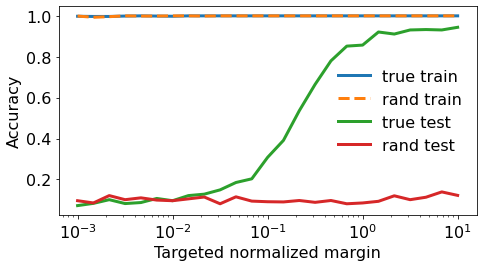

In [38]:
fname = fnames[2]
f = open(fname, 'rb')
results_dict = pickle.load(f)
f.close()

train_acc = [results_dict['true_data_results']['train_acc_list'][idx][-1] for idx, _ in enumerate(results_dict['parameters']['scale_vector'])]
scale_vector = results_dict['parameters']['scale_vector']
test_acc = [results_dict['true_data_results']['test_acc_list'][idx][-1] for idx, _ in enumerate(results_dict['parameters']['scale_vector'])]

rand_train_acc = [results_dict['rand_data_results']['train_acc_list'][idx][-1] for idx, _ in enumerate(results_dict['parameters']['scale_vector'])]
rand_test_acc = [results_dict['rand_data_results']['test_acc_list'][idx][-1] for idx, _ in enumerate(results_dict['parameters']['scale_vector'])]


alpha=1
plt.plot(scale_vector, train_acc, marker='', label='true train', alpha=alpha)
plt.plot(scale_vector, rand_train_acc, marker='', label='rand train', linestyle='--', alpha=alpha)
plt.plot(scale_vector, test_acc, marker='', label='true test', alpha=alpha)
plt.plot(scale_vector, rand_test_acc, marker='', label='rand test', alpha=alpha)
plt.xscale('log')
# plt.ylim([0,1])
plt.legend()
plt.xlabel('Targeted normalized margin')
plt.ylabel('Accuracy')
plt.tight_layout()
# plt.savefig("nero_em_train_vs_rand.pdf")